<h2>Import Preprocessed Data</h2>

In [31]:
#Custom function for data cleaning and preprocessing 
from data_cleaning import *                             
df = dataCleaning('./CSV/iphone_dataset.csv')

In [61]:
mydf = df
def categorize(row):
    if row['review_helpful_vote'] <= 10:
        return 0
    elif row['review_helpful_vote'] > 10 and row['review_helpful_vote'] <= 100:
        return 1
    elif row['review_helpful_vote'] > 100:
        return 2


# mydf['helpfulness'] = mydf.apply(lambda row :categorize(row), axis = 1)
mydf['helpfulness'] = mydf['review_helpful_vote'] > 0

mydf.head()

,review_rating,review_helpful_vote,review,lemmatized,helpfulness
0,3,5087,note,[note],True
1,1,2822,very bad experience with this iphone xr phone ...,"[bad, experience, iphone, xr, phone, back, cam...",True
2,5,1798,amazing phone with amazing camera coming from ...,"[amazing, phone, amazing, camera, coming, ipho...",True
3,1,1366,so i got the iphone xr just today the product...,"[got, iphone, xr, today, product, look, amazin...",True
4,5,536,i have been an android user all my life until ...,"[android, user, life, decided, try, iphone, xr...",True


<h2>Word2Vec Embeddings</h2>

In [62]:
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

In [63]:
X_train, X_test, y_train, y_test = train_test_split(mydf['lemmatized'], mydf['helpfulness'], test_size = 0.3)
# text_tokens = mydf['lemmatized'].tolist()[1:]
# model = Word2Vec(sentences=text_tokens, vector_size=100, window=5, min_count=4, workers=4,sg=1)
model = Word2Vec(X_train, vector_size=100, window=5, min_count=2)

<h3>Data Analysis using Embeddings</h3>

In [64]:
# Top 10 most similar words 
sims = model.wv.most_similar('iphone', topn=10)
sims

[('apple', 0.999664843082428),
 ('gb', 0.9996500015258789),
 ('go', 0.9996466636657715),
 ('much', 0.9996383190155029),
 ('experience', 0.9996351599693298),
 ('model', 0.9996249079704285),
 ('phone', 0.99962317943573),
 ('think', 0.9996156096458435),
 ('xr', 0.9996151328086853),
 ('device', 0.9996131658554077)]

c:\Users\hp\anaconda3\envs\felix_env\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\hp\anaconda3\envs\felix_env\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


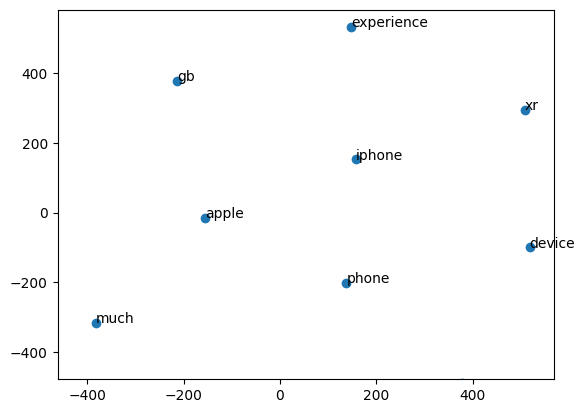

In [65]:
from tsne_closest_words import *
display_closestwords_tsne_plot(model,'iphone')

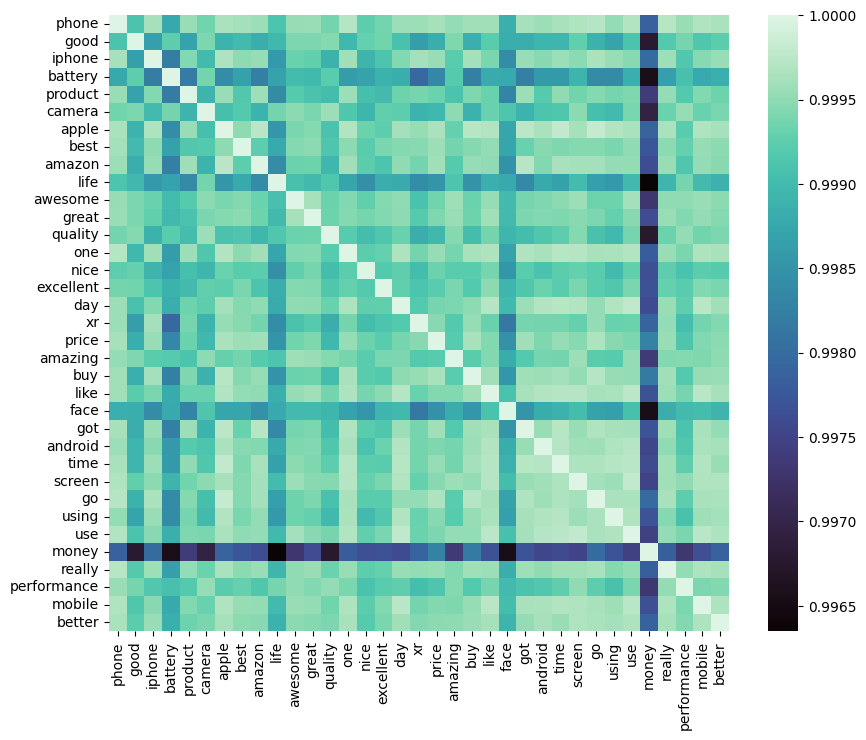

In [66]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns 

words = mydf['lemmatized']
allwords = []
embeddings_vector = []

for wordlist in words:
    allwords += wordlist
    
from nltk.probability import FreqDist
mostcommon = FreqDist(allwords).most_common(35)
for word,freq in mostcommon:
    embeddings_vector.append(model.wv[word])
embeddings_vector = np.array(embeddings_vector)

sim_matrix = cosine_similarity(embeddings_vector)
mostcommon = [word for word,freq in mostcommon]
sims_df = pd.DataFrame(sim_matrix,columns = mostcommon)
sims_df.index = mostcommon


plt.figure(figsize = (10,8))
sns.heatmap(sims_df, cmap = 'mako')
plt.show()

<h2>Training ML Model</h2>

In [67]:
words = set(model.wv.index_to_key)
X_train_vect = np.array([np.array([model.wv[i] for i in ls if i in words]) for ls in X_train])
X_test_vect = np.array([np.array([model.wv[i] for i in ls if i in words]) for ls in X_test])

X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100,dtype=float))

X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100,dtype=float))

c:\Users\hp\anaconda3\envs\felix_env\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
c:\Users\hp\anaconda3\envs\felix_env\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


<h3>Random Forest Classifier</h3>

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix



In [83]:
rf = RandomForestClassifier(class_weight={0: 380,1 : 1700})
rf_model = rf.fit(X_train_vect_avg,y_train.values.ravel())
y_pred = rf_model.predict(X_test_vect_avg)
confusion_matrix(y_test,y_pred)


In [90]:
lr = LogisticRegression(class_weight={0:300},max_iter=1000)
lr_model = lr.fit(X_train_vect_avg,y_train.values.ravel())
y_pred = lr_model.predict(X_test_vect_avg)
confusion_matrix(y_test,y_pred)

(array([1106.,  174.,   25.,   20.]),
 array([  1,   4,  25,  50, 100]),
 <BarContainer object of 4 artists>)

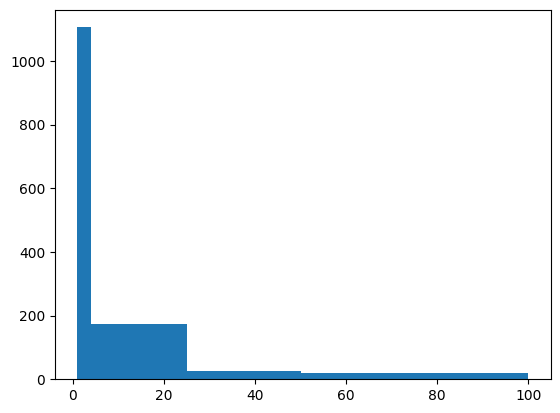

In [58]:
plt.hist(mydf.loc[mydf['review_helpful_vote'] != 0, 'review_helpful_vote'], bins = [1,4,25,50,100])

In [50]:
mydf.loc[mydf['review_helpful_vote'] != 0, 'review_helpful_vote'].describe()

count    1357.000000
mean       25.574060
std       244.217684
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max      5087.000000
Name: review_helpful_vote, dtype: float64

In [60]:
mydf['review_helpful_vote'].value_counts()

0      5653
1       840
2       195
3        71
4        32
       ... 
53        1
54        1
28        1
29        1
412       1
Name: review_helpful_vote, Length: 76, dtype: int64

In [103]:
pd.merge(pd.DataFrame(X_train_vect_avg), y_train, left_index=True, right_index=True).to_csv('trainer.csv')
pd.merge(pd.DataFrame(X_test_vect_avg), y_test, left_index=True, right_index=True).to_csv('tester.csv')

In [111]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("trainer.csv")
test = h2o.import_file("tester.csv")

# Identify predictors and response
x = train.columns
y = "C102"
x.remove(y)
x.remove("C1")

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
 # Print all rows instead of default (10 rows)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,23 mins 34 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_hp_rs0d42
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.930 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
22:52:21.436: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


model_id,mean_per_class_error,logloss,rmse,mse
GBM_4_AutoML_1_20221011_225221,0.66444,0.491057,0.377952,0.142848
GBM_grid_1_AutoML_1_20221011_225221_model_1,0.664797,0.503454,0.379103,0.143719
XRT_1_AutoML_1_20221011_225221,0.665368,0.471468,0.371226,0.137809
DRF_1_AutoML_1_20221011_225221,0.665368,0.471084,0.371687,0.138151
GBM_grid_1_AutoML_1_20221011_225221_model_4,0.665496,0.484404,0.376133,0.141476
GBM_grid_1_AutoML_1_20221011_225221_model_3,0.66561,0.473026,0.374606,0.14033
GBM_3_AutoML_1_20221011_225221,0.665839,0.484157,0.376668,0.141879
DeepLearning_grid_1_AutoML_1_20221011_225221_model_2,0.666146,0.461512,0.361913,0.130981
GBM_grid_1_AutoML_1_20221011_225221_model_5,0.666167,0.509431,0.382024,0.145943
GBM_2_AutoML_1_20221011_225221,0.666295,0.475247,0.374223,0.140043
